# Integration of stiff ODEs

#### Benjamin Vogel 

In [11]:
import numpy as np
import scipy as scp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

## 2.  Brusselator

#### The Model

In [12]:
#
# defining the model and exact solution
#

def model(t,y,alpha=1,beta=3):
    '''
    t : current time t
    y : evaluation of y at time t
    l : lambda parameter > 1
    '''
    
    dy = np.zeros(2)
    dy[0] += 1 + alpha*(y[0]**2)*y[1] - (1+beta)*y[0]
    dy[1] += -alpha*(y[0]**2)*y[1] + beta*y[0]
    return dy

### Definition of Integration Methods

In [13]:
#
# previously defined methods
#

def forward_euler(f,y,h,t):
    '''
    f   : ODE function f(t,y(t))
    y   : current evaluation
    h   : time step size
    t   : current time
    
    uses left euler method to approximate integral 
    '''
    return y + h * f(t,y), t+h , h


def backward_euler(f,y,h,t):
    def implicit_eq(y_next):
        return y_next - y - h * f(t + h, y_next)
    y_next = fsolve(implicit_eq, y)
    return y_next, t+h , h


def explicit_RK_2(f,y,h,t):
    '''
    f   : ODE function f(t,y(t))
    y   : current evaluation
    h   : time step size
    t   : current time
    
    uses second order Runge-Kutta method to approximate integral 
    '''
    k1 = f(t,y)
    k2 = f(t+h/2, y + (h/2)*k1)
    return y + h*k2, t+h , h

In [14]:
#
# RK-4 Implementation
#

def explicit_RK_4(f,y,h,t):
    '''
    f   : ODE function f(t,y(t))
    y   : current evaluation
    h   : time step size
    t   : current time
    
    uses fourth order Runge-Kutta method to approximate integral 
    '''
    k1 = f(t,y)
    k2 = f(t+h/2, y+(h/2)*k1)
    k3 = f(t+h/2, y+(h/2)*k2)
    k4 = f(t+h, y + h*k3)
    return y + (h/6)*(k1+2*k2+2*k3+k4), t+h , h

In [66]:
#
# Embedded RK-3
#
def embedd_RK_3(f,y,h,t,tol=1e-9):
    '''
    f   : ODE function f(t,y(t))
    y   : current evaluation
    h   : time step size
    t   : current time
    tol : tolerance used to compute opt h
    '''
    c1 = 0
    c2 = 1/3
    c3 = 2/3
    c4 = 1
    
    b1 = 1/8
    b2 = 3/8
    b3 = 3/8
    b4 = 1/8
    
    k1 = f(t,y)
    k2 = f(t + c2*h , y + (h/3)*k1)
    k3 = f(t + c3*h , y - (h/3)*k1 + h*k2)
    k4 = f(t + c4*h , y + h* (k1 - k2 + k3))
    
    y1 = y + h*(b1*k1 + b2*k2 + b3*k3 + b4*k4)
    
    b1_hat = 2*b1 - 1/6
    b2_hat = 2*(1-c2)*b2
    b3_hat = 2*(1-c3)*b3
    b4_hat = 0
    b5_hat = 1/6

    k5 = f(t+ h, y1)
    
    y1_hat = y + h*(b1_hat*k1 + b2_hat*k2 + b3_hat*k3 + b4_hat*k4 + b5_hat*k5)
    
    err = np.sqrt(np.mean(np.power((y1-y1_hat)/(1+np.maximum(np.abs(y1),np.abs(y1_hat))),2)))
    
    opt_step1 = 0.9 * (tol/err)**(1/(3+1))
    opt_h = h*np.minimum(5, np.maximum(0.2, opt_step1))
    
    if err <= tol:
        return y1 , t + h, opt_h
    else:
        return y1 , t, opt_h

In [67]:
#
# defining the IVP solver
#

def IVP(f,y_init,h,time,method=forward_euler):
    # storage for evaluations at every iteration
    steps = [y_init]
    t_values = [0]
    current_time = 0
    y_current = y_init
    h_step = h
    
    while current_time < time:
        y_next, t_next, h_next = method(f, y_current, h_step, current_time)
        if np.isclose(t_next,current_time):
            h_step = h_next
        else:
            steps.append(y_next)
            current_time += h_step
            t_values.append(current_time)
            
            h_step = np.minimum(h_next, time-h_step)
            y_current = y_next
    
    return np.array(t_values), np.array(steps)

### What is Radau5 and how does it work?
Radau5 is a fully implicit 5th order runge-kutta method and is part of the Radau IIA methods. The method also uses a 3rd order embeded method to approximate errors and adapt the step size.

Regarding the radau methods butcher table, one node is fixed. 
For the Radau5 method, the fixed node is the right endpoint (at x=1). For an s=3 stage method, the nodes $c_i$ are the roots of the equation: $$\frac{d^{s-1}}{dx^{s-1}}(x^{s-1}(x-1)^s)$$
The weights $b_i$ for the Radau methods are chosen using the quadrature conditions:
$$\sum_{i=1}^s b_i c_i^{q-1} = \frac{1}{q} \quad \forall \text{q=1,...,s}$$ 

Because Radau5 is a implicit method, a nonlinear equation(s) has to be iteratively solved. Newtons method is used to solve these nonlinear equations, having to solve a linear system of equations every step. The system is going to be the size of "number of stages $s$ times number of differential equations $n$". Because this is increadibly expensive to solve, the $n$ times $s$ dimensional system gets decomposed into s n-dimensional systems.

Radau methods are A-stable methods, meaning that the stability domain covers $\mathbb{C}^-$

Sources:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.Radau.html#r04c194a64501-1
https://www.sciencedirect.com/science/article/pii/S037704279900134X

### Stiffness of the system

#### Plot IVP (Experimentation)

In [68]:
#
# the following function plots IVP with different time steps and plots
#
def plot_IVP(f,y_init,time,six_time_steps=[0.01,0.1,0.2,0.3,0.4,0.5],method=forward_euler):
    '''
    plots y_n+1 / y_n along side the acctual outputs
    '''
    fig, axs = plt.subplots(3, 2, figsize=(15, 10)) 
    axs = axs.flatten()
    steps = six_time_steps
    k = 0
    for h in steps:
        ts,vs = IVP(f,y_init,h,time,method)
        amp = []
        for idx in range(len(vs)-1):
            r = (vs[idx+1]/vs[idx])
            amp.append(r)
        #axs[k].plot(ts[1:],amp, label=f"amplification")
        axs[k].plot(ts,vs, label=f"IVP")
        axs[k].set_title(f"h = {h}")
        axs[k].set_xlabel(f"t")
        axs[k].set_ylim(-5,5)
        axs[k].legend()
        axs[k].grid()
        k += 1
    fig.tight_layout()
    

C:\Users\benvo\AppData\Local\Temp\ipykernel_3188\4115658183.py:13: RuntimeWarning: overflow encountered in scalar power
  dy[0] += 1 + alpha*(y[0]**2)*y[1] - (1+beta)*y[0]
C:\Users\benvo\AppData\Local\Temp\ipykernel_3188\4115658183.py:14: RuntimeWarning: overflow encountered in scalar power
  dy[1] += -alpha*(y[0]**2)*y[1] + beta*y[0]
C:\Users\benvo\AppData\Local\Temp\ipykernel_3188\3636679212.py:14: RuntimeWarning: invalid value encountered in add
  return y + h * f(t,y), t+h , h
C:\Users\benvo\AppData\Local\Temp\ipykernel_3188\4115658183.py:13: RuntimeWarning: overflow encountered in scalar multiply
  dy[0] += 1 + alpha*(y[0]**2)*y[1] - (1+beta)*y[0]
C:\Users\benvo\AppData\Local\Temp\ipykernel_3188\4115658183.py:14: RuntimeWarning: overflow encountered in scalar multiply
  dy[1] += -alpha*(y[0]**2)*y[1] + beta*y[0]
C:\Users\benvo\AppData\Local\Temp\ipykernel_3188\2995815982.py:16: RuntimeWarning: divide by zero encountered in divide
  r = (vs[idx+1]/vs[idx])


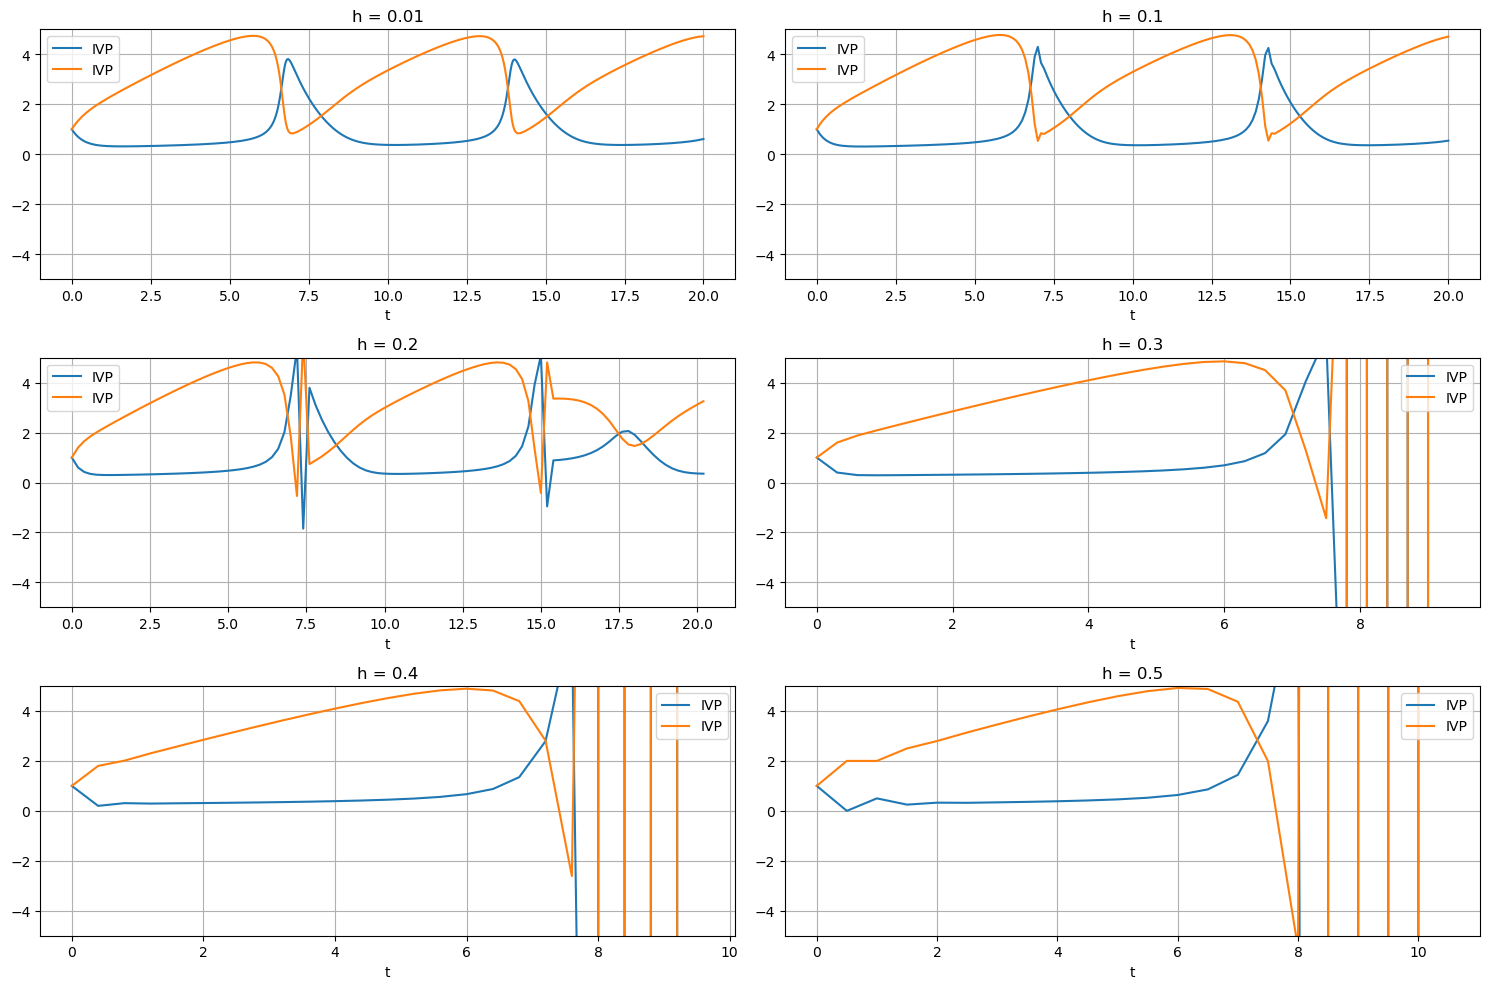

In [69]:
#
# forward euler
#
m = lambda t,y : model(t,y)
plot_IVP(m,np.array([1,1]),20)

C:\Users\benvo\AppData\Local\Temp\ipykernel_3188\4115658183.py:13: RuntimeWarning: overflow encountered in scalar multiply
  dy[0] += 1 + alpha*(y[0]**2)*y[1] - (1+beta)*y[0]
C:\Users\benvo\AppData\Local\Temp\ipykernel_3188\4115658183.py:14: RuntimeWarning: overflow encountered in scalar multiply
  dy[1] += -alpha*(y[0]**2)*y[1] + beta*y[0]
C:\Users\benvo\AppData\Local\Temp\ipykernel_3188\3636679212.py:34: RuntimeWarning: invalid value encountered in add
  k2 = f(t+h/2, y + (h/2)*k1)
C:\Users\benvo\AppData\Local\Temp\ipykernel_3188\4115658183.py:13: RuntimeWarning: overflow encountered in scalar power
  dy[0] += 1 + alpha*(y[0]**2)*y[1] - (1+beta)*y[0]
C:\Users\benvo\AppData\Local\Temp\ipykernel_3188\4115658183.py:14: RuntimeWarning: overflow encountered in scalar power
  dy[1] += -alpha*(y[0]**2)*y[1] + beta*y[0]


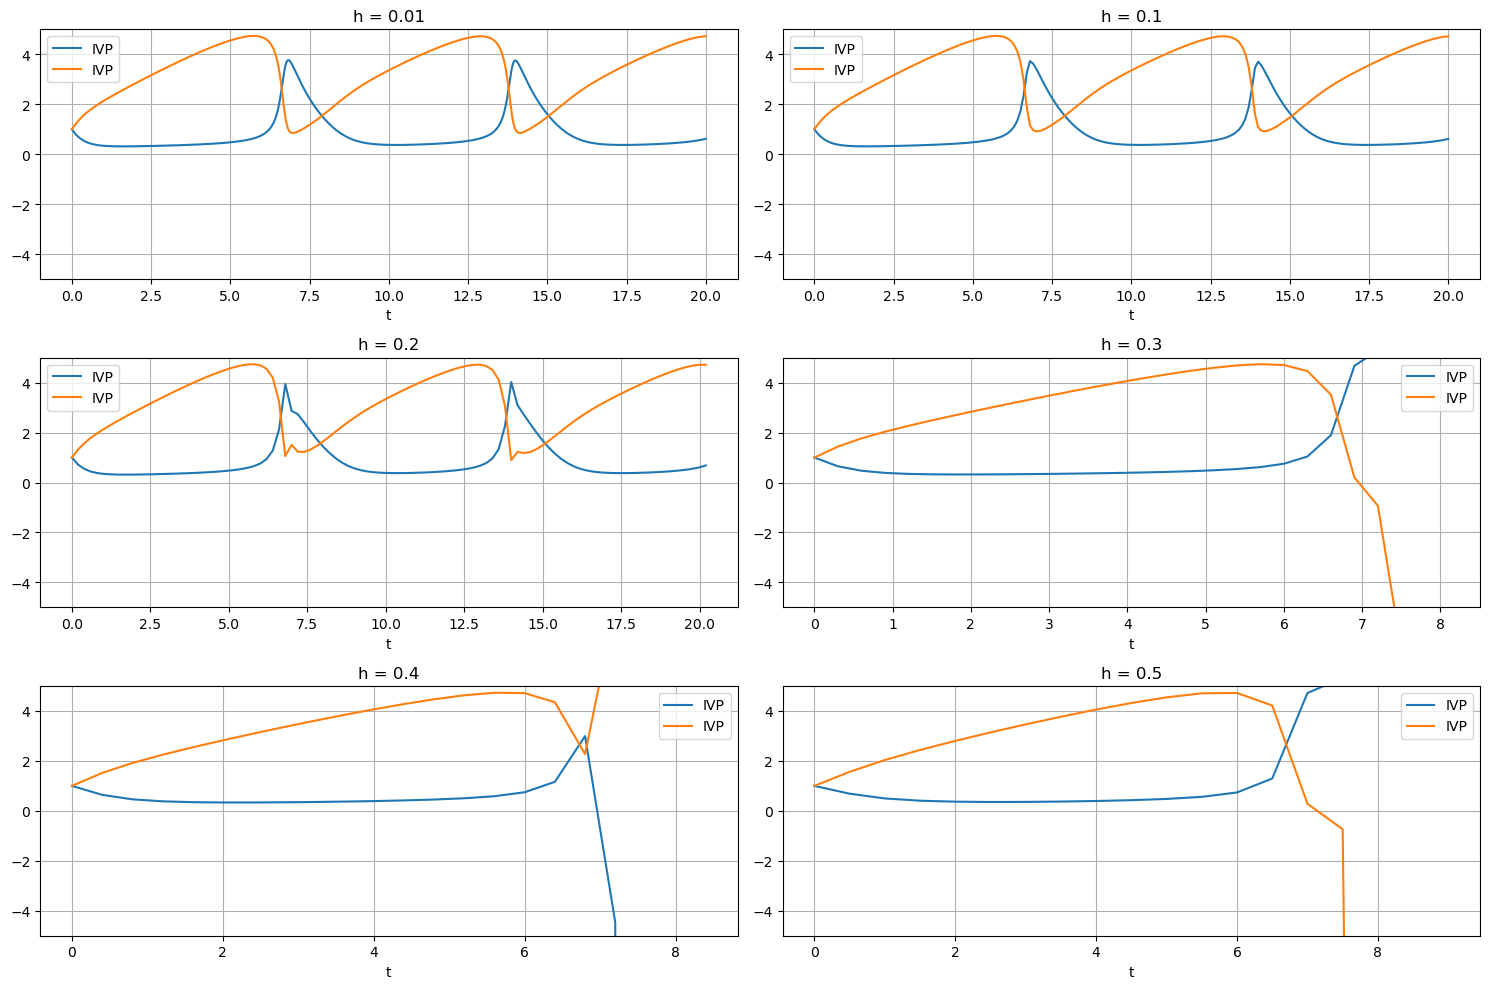

In [70]:
#
# 2-RK
#
m = lambda t,y : model(t,y)
plot_IVP(m,np.array([1,1]),20,method=explicit_RK_2)

C:\Users\benvo\AppData\Local\Temp\ipykernel_3188\3636679212.py:20: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  y_next = fsolve(implicit_eq, y)
C:\Users\benvo\AppData\Local\Temp\ipykernel_3188\3636679212.py:20: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  y_next = fsolve(implicit_eq, y)


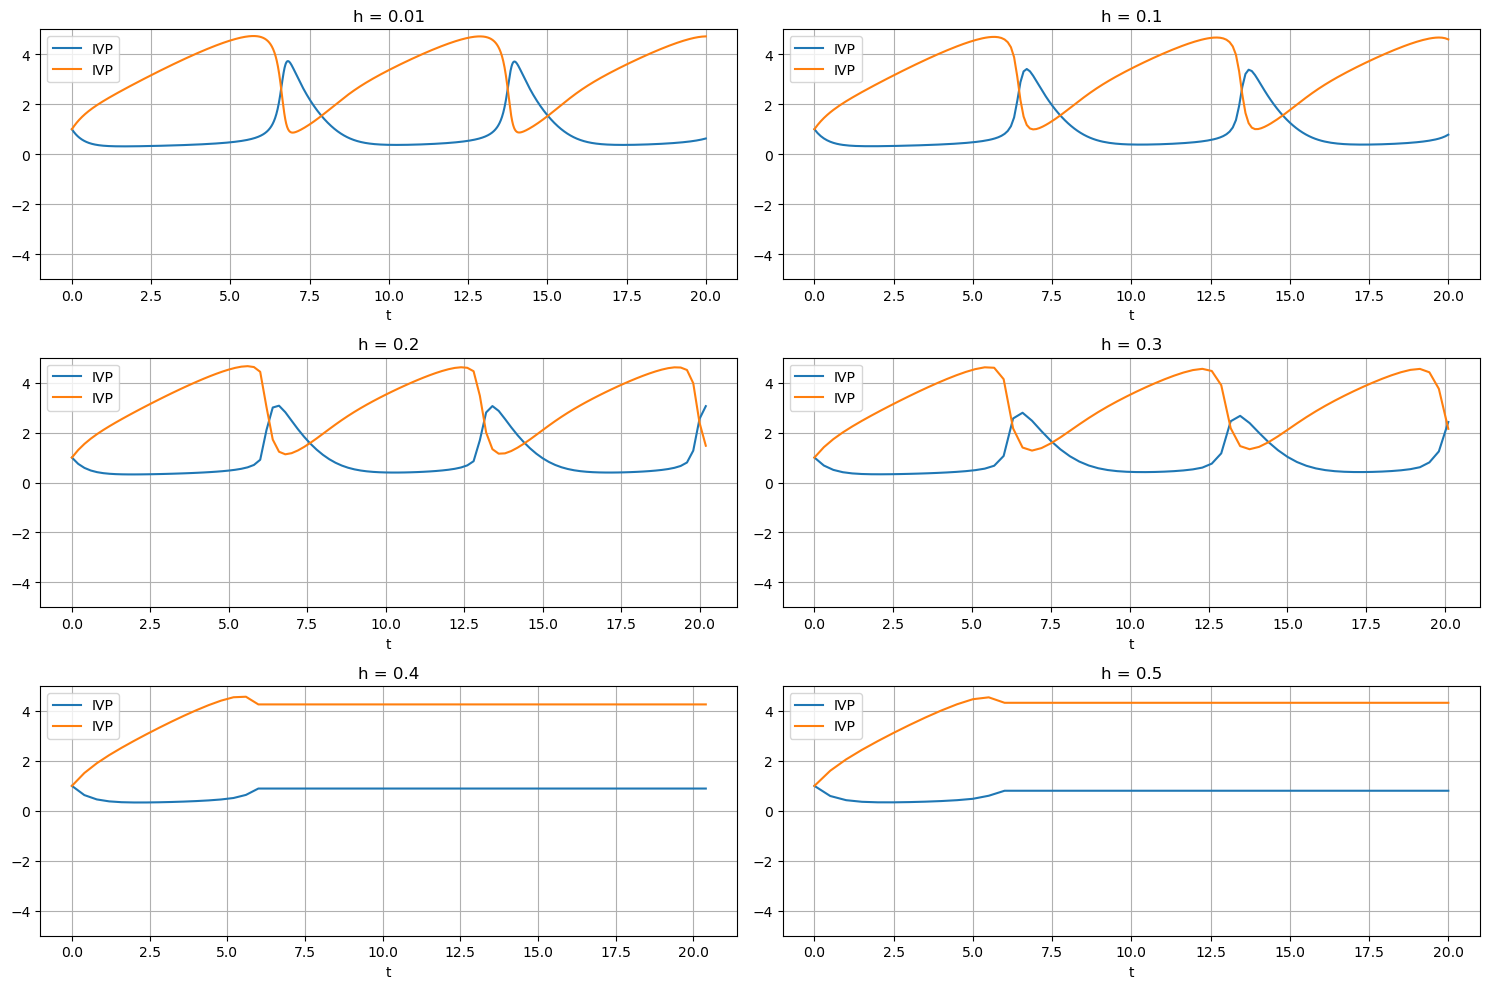

In [71]:
m = lambda t,y : model(t,y)
plot_IVP(m,np.array([1,1]),20,method=backward_euler)

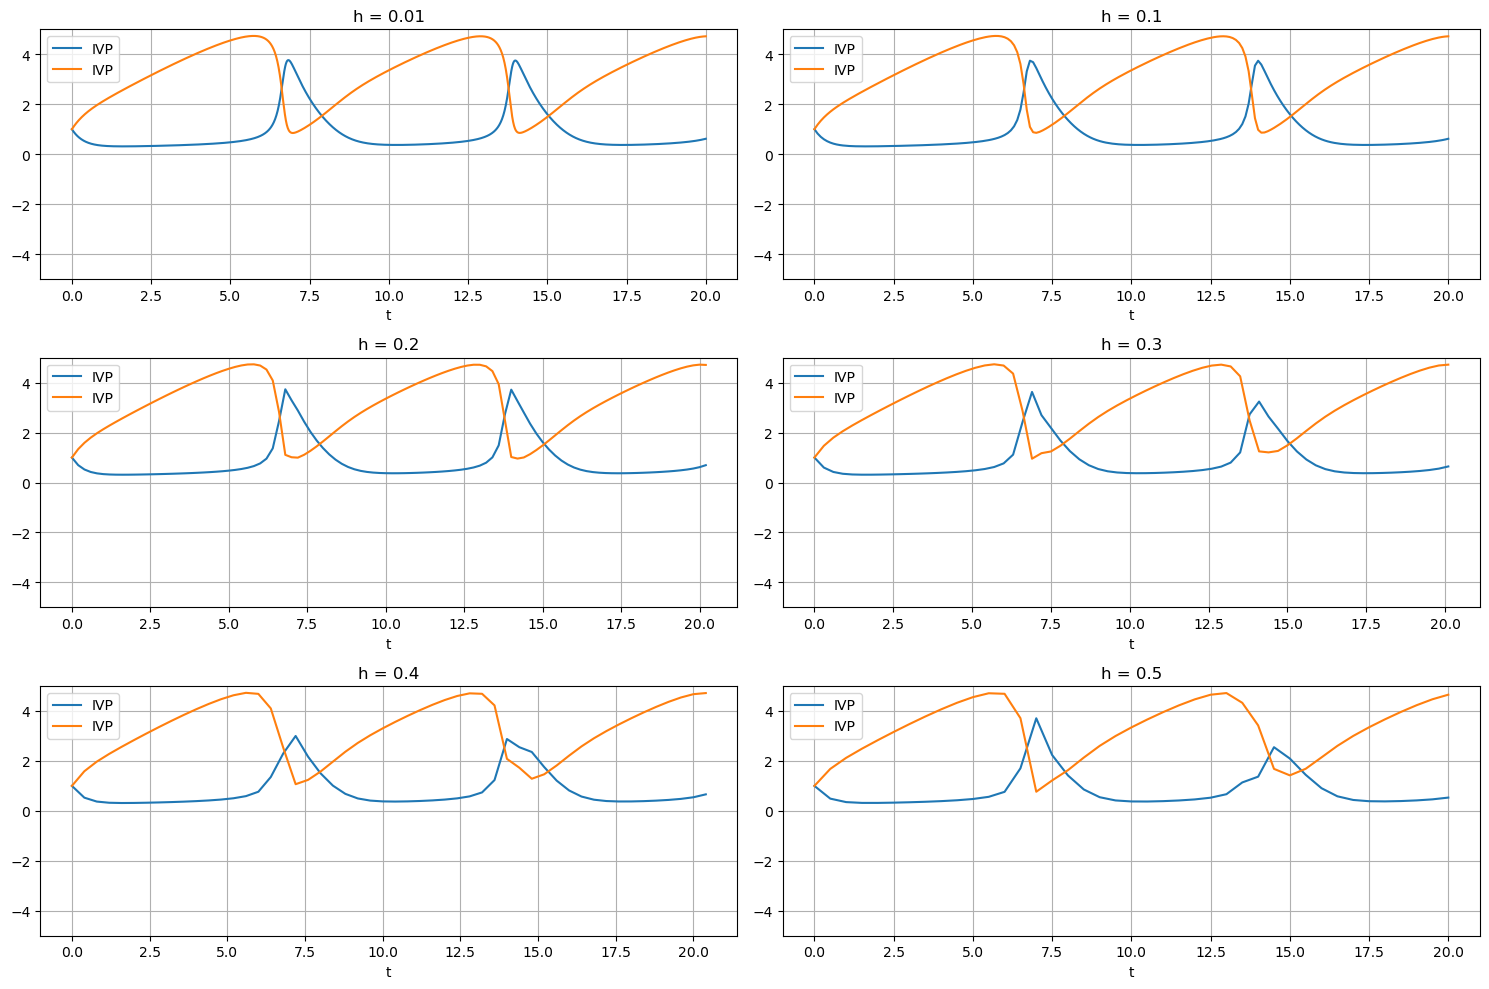

In [72]:
m = lambda t,y : model(t,y)
plot_IVP(m,np.array([1,1]),20,method=explicit_RK_4)

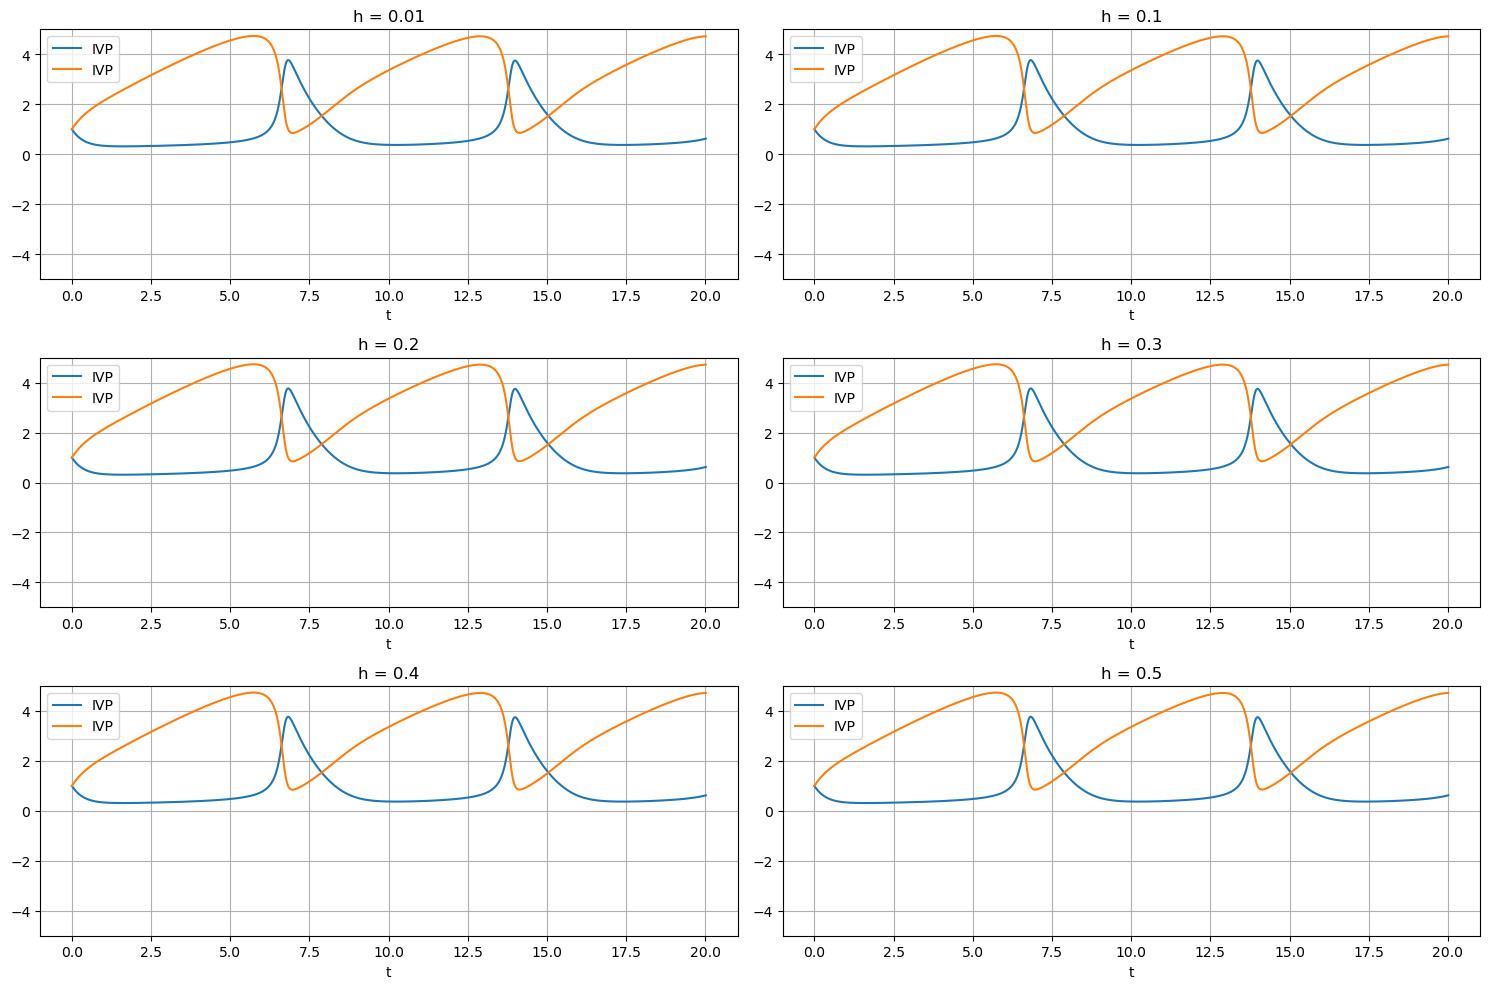

In [73]:
m = lambda t,y : model(t,y)
plot_IVP(m,np.array([1,1]),20,method=embedd_RK_3)

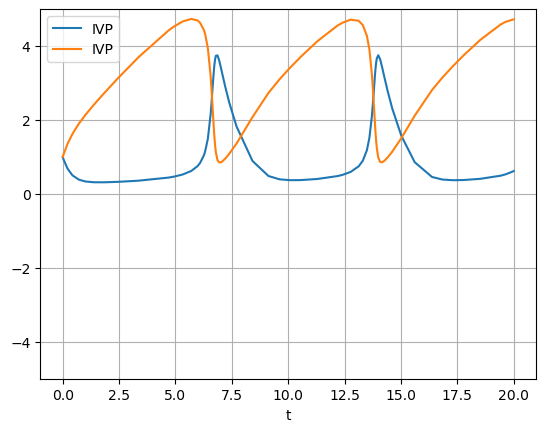

In [74]:
m = lambda t,y : model(t,y)

def radau_gen(f,y,t):
    rad_obj = scp.integrate.Radau(f,0,y,t)
    while True:
        rad_obj.step()
        yield rad_obj.y, rad_obj.t, rad_obj.step_size
        if rad_obj.t == t:
            break
ts = [0]
ys = [[1,1]]
for y,t,h in radau_gen(m,np.array([1,1]),20):
    ts.append(t)
    ys.append(y)
    
plt.plot(ts,ys, label=f"IVP")
plt.xlabel(f"t")
plt.ylim(-5,5)
plt.legend()
plt.grid()

### Stability limits of the explicit methods

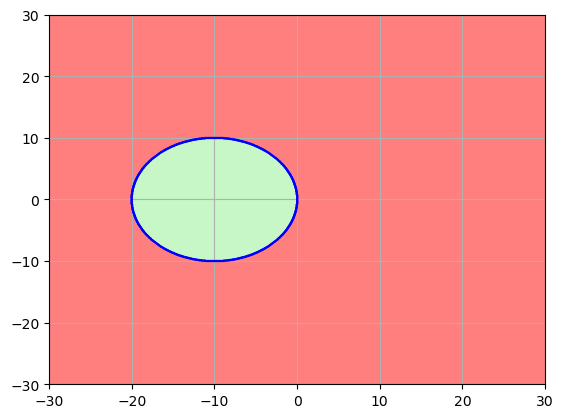

In [96]:
#
# explicit euler
#
delta_t = 0.1
x_space = np.linspace(-30,30,1000)
y_space = np.linspace(-30,30,1000)
X, Y = np.meshgrid(x_space,y_space)
def re(r,c):
    weights = [1,1]
    complex_n = delta_t*(r + c*1j)
    powers = [weights[i]*complex_n**i for i in range(0,2)]
    total = sum(powers)
    norm = np.sqrt(total.real**2 + total.imag**2) 
    return norm

condition = re(X,Y)
plt.contourf(X, Y, condition, levels=[0,1], colors=['lightgreen'], alpha=0.5)
plt.contourf(X, Y, condition, levels=[1,10], colors=['red'], alpha=0.5)
condition = re(X,Y) < 1
plt.contour(X, Y, condition, levels=1, colors='blue')   
plt.grid()

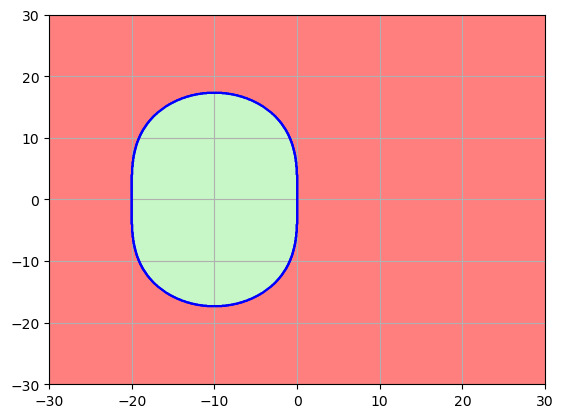

In [97]:
#
# RK-2
#
delta_t = 0.1
x_space = np.linspace(-30,30,1000)
y_space = np.linspace(-30,30,1000)
X, Y = np.meshgrid(x_space,y_space)
def re(r,c):
    weights = [1,1, 1/2]
    complex_n = delta_t*(r + c*1j)
    powers = [weights[i]*complex_n**i for i in range(0,3)]
    total = sum(powers)
    norm = np.sqrt(total.real**2 + total.imag**2) 
    return norm

condition = re(X,Y)
plt.contourf(X, Y, condition, levels=[0,1], colors=['lightgreen'], alpha=0.5)
plt.contourf(X, Y, condition, levels=[1,30], colors=['red'], alpha=0.5)
condition = re(X,Y) < 1
plt.contour(X, Y, condition, levels=1, colors='blue')   
plt.grid()

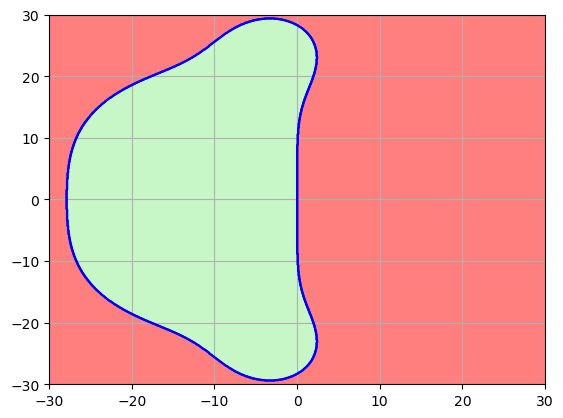

In [98]:
#
# RK-4
#
delta_t = 0.1
x_space = np.linspace(-30,30,1000)
y_space = np.linspace(-30,30,1000)
X, Y = np.meshgrid(x_space,y_space)
def re(r,c):
    weights = [1,1, 1/2,1/6, 1/24]
    complex_n = delta_t*(r + c*1j)
    powers = [weights[i]*complex_n**i for i in range(0,5)]
    total = sum(powers)
    norm = np.sqrt(total.real**2 + total.imag**2) 
    return norm

condition = re(X,Y)
plt.contourf(X, Y, condition, levels=[0,1], colors=['lightgreen'], alpha=0.5)
plt.contourf(X, Y, condition, levels=[1,50], colors=['red'], alpha=0.5)

condition = re(X,Y) < 1
plt.contour(X, Y, condition, levels=1, colors='blue')   
plt.grid()

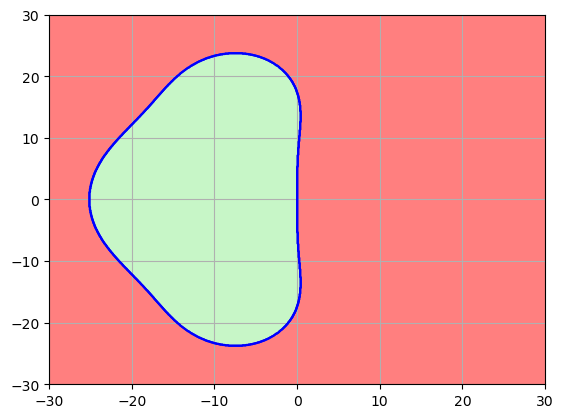

In [99]:
#
# RK-3
#
delta_t = 0.1
x_space = np.linspace(-30,30,1000)
y_space = np.linspace(-30,30,1000)
X, Y = np.meshgrid(x_space,y_space)
def re(r,c):
    weights = [1,1, 1/2,1/6]
    complex_n = delta_t*(r + c*1j)
    powers = [weights[i]*complex_n**i for i in range(0,4)]
    total = sum(powers)
    norm = np.sqrt(total.real**2 + total.imag**2) 
    return norm

condition = re(X,Y)
plt.contourf(X, Y, condition, levels=[0,1], colors=['lightgreen'], alpha=0.5)
plt.contourf(X, Y, condition, levels=[1,50], colors=['red'], alpha=0.5)

condition = re(X,Y) < 1
plt.contour(X, Y, condition, levels=1, colors='blue')   
plt.grid()

### Drawbacks of explicit methods with fast and slow dynamics

The main issue with using explicit methods with fast and slow dynamics is choosing the step size. Because there are fast dynamics, it is important to have a small step size to ensure stability and convergences. However this causes unnecessary computational costs for the dynamically slow periods of the problem, because many steps are taken for regions where such accuracy is not needed. 

Similarly, when taking a larger step size to reduce the computational cost of the periods with slow dynamics, the fast dynamical regions loose wont be computed accurately.

The phenomena limiting the timestep is Numerical stability. If the time step becomes too large, errors diverge very fast which leads to large errors.

### Why is the Embedded Runge Kutta Method efficient?

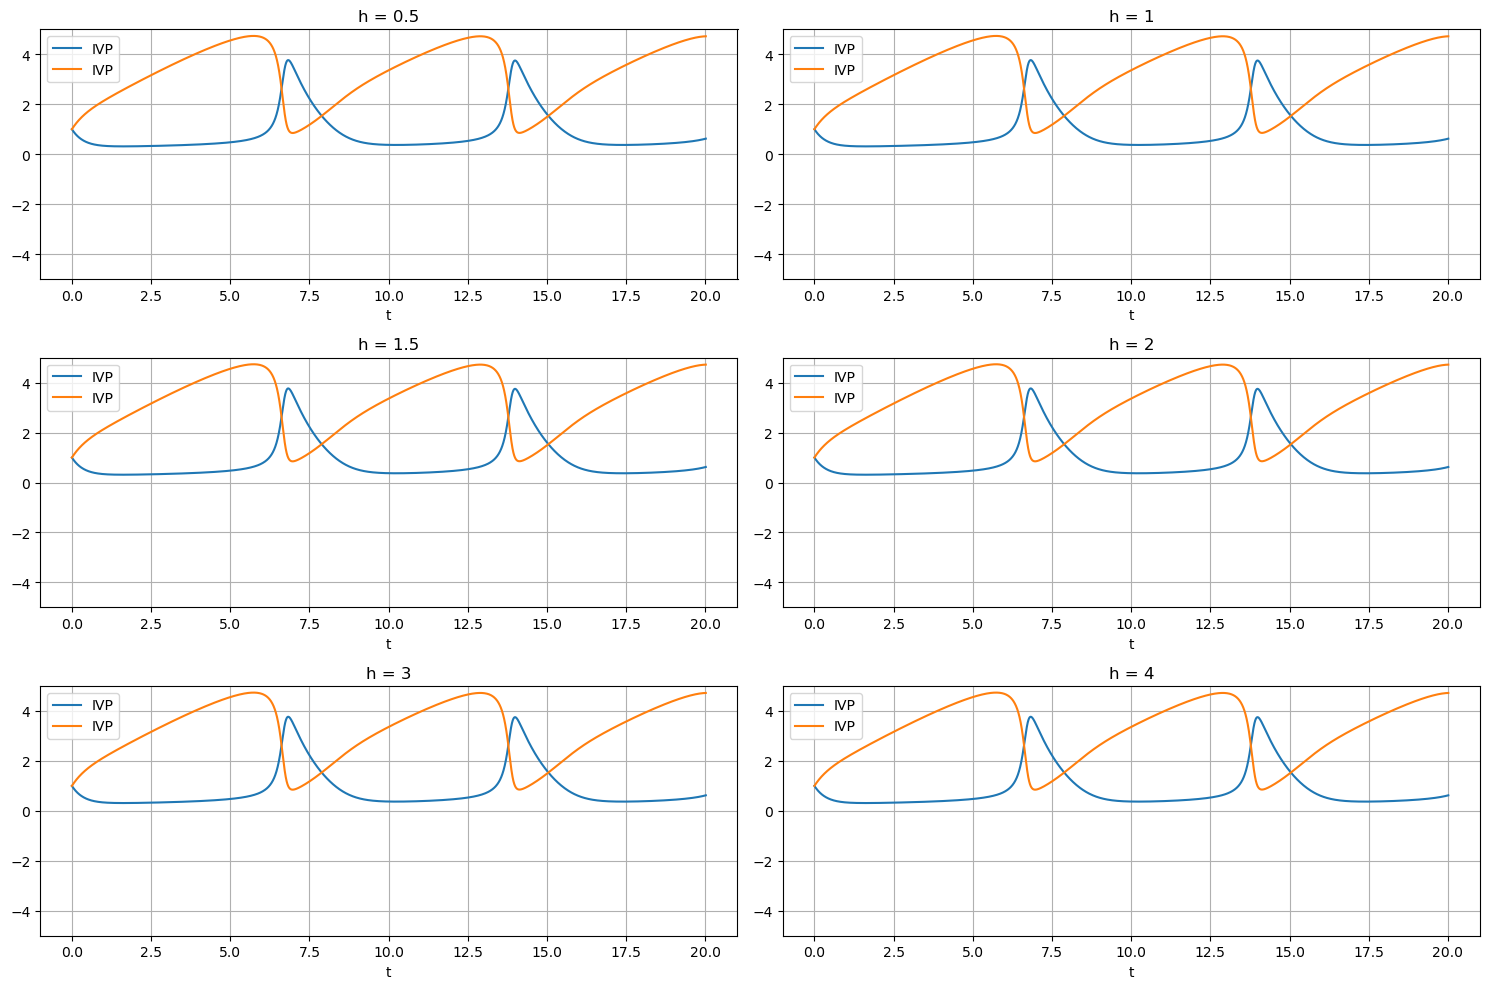

In [79]:
#
# technically testing the method for multiple time steps is unnecessary as the embedded method controlls the time step itself
#
m = lambda t,y : model(t,y)
plot_IVP(m,np.array([1,1]),20,method=embedd_RK_3, six_time_steps=[0.5,1,1.5,2,3,4])

The embedded Runge-Kutta method is so efficient for this problem because it it adapts its step size in accordance with the dynamics of the system. When the system is in a slow-dynamic state, the embeded method notices small differences in the different order methods and thus is able to take larger time steps. However, when the system reaches its fast-dynamic region, the embedded method adapts and reduced the step size such that the fast-dynamic behaviour are accuractely computed.


Wrong
The embedded Runge-Kutta method is thrid order because the system contains elements such as $y_1^2 y_2$. If we consider $y_1$ and $y_2$ to be variables for a function $f(t,y_1,y_2)$, we can derivate three times until there is no further information to gather on the behaviour of our function. Hence, a fourth order method would not improve the accuracy, whereas a second order method would capture less of the systems behaviour.



### Stability of the Implicit Euler Method

C:\Users\benvo\AppData\Local\Temp\ipykernel_3188\3636679212.py:20: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  y_next = fsolve(implicit_eq, y)
C:\Users\benvo\AppData\Local\Temp\ipykernel_3188\3636679212.py:20: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  y_next = fsolve(implicit_eq, y)


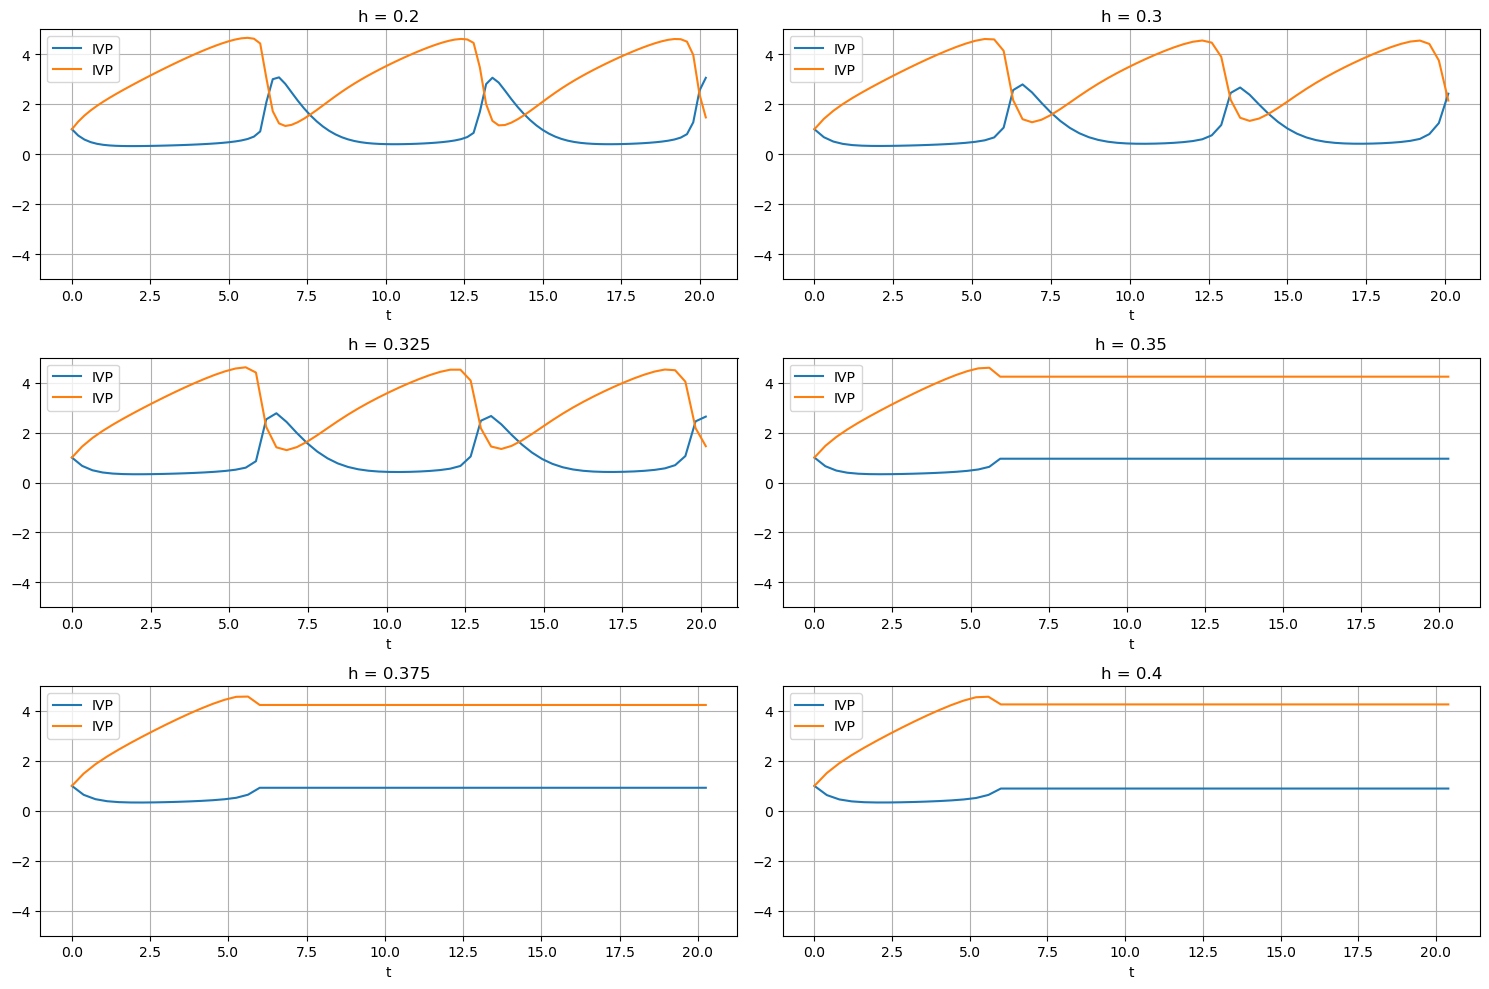

In [80]:
m = lambda t,y : model(t,y)
plot_IVP(m,np.array([1,1]),20,method=backward_euler,six_time_steps=[0.2,0.3,0.325,0.35,0.375,0.4])

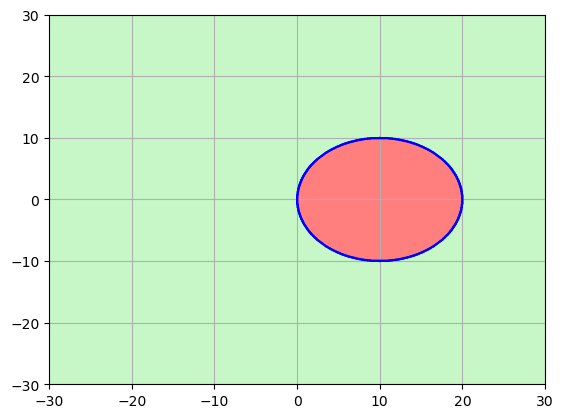

In [105]:
#
# implicit euler
#
delta_t = 0.1
x_space = np.linspace(-30,30,1000)
y_space = np.linspace(-30,30,1000)
X, Y = np.meshgrid(x_space,y_space)
def re(r,c):
    complex_n = r + c*1j
    total = 1/(1-delta_t*complex_n)
    norm = np.sqrt(total.real**2 + total.imag**2) 
    return norm

condition = re(X,Y)
plt.contourf(X, Y, condition, levels=[0,1], colors=['lightgreen'], alpha=0.5)
plt.contourf(X, Y, condition, levels=[1,100], colors=['red'], alpha=0.5)
condition = re(X,Y) < 1
plt.contour(X, Y, condition, levels=1, colors='blue')   
plt.grid()

The implicit euler method is stable for most time steps. If we surpase that threshold, the implicit method fails and determines that the quantities of both particles remain constant. The explicit euler method needs a time step of around 0.01 to be stable, the implicit euler method is stable with time steps between 0.2 and 0.3

### Radau5

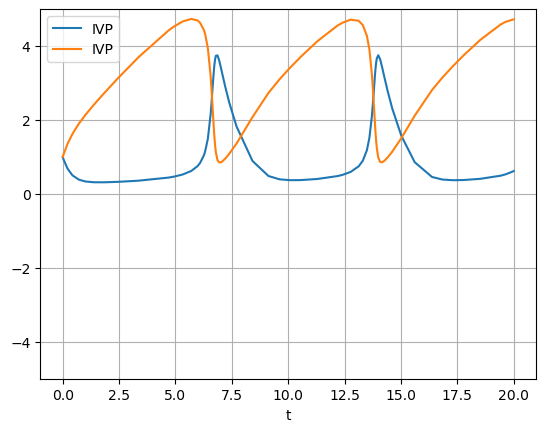

In [110]:
m = lambda t,y : model(t,y)
steps = []
def radau_gen(f,y,t):
    rad_obj = scp.integrate.Radau(f,0,y,t)
    while True:
        rad_obj.step()
        steps.append(rad_obj.step_size)
        yield rad_obj.y, rad_obj.t, rad_obj.step_size
        if rad_obj.t == t:
            break
ts = [0]
ys = [[1,1]]
for y,t,h in radau_gen(m,np.array([1,1]),20):
    ts.append(t)
    ys.append(y)
    
plt.plot(ts,ys, label=f"IVP")
plt.xlabel(f"t")
plt.ylim(-5,5)
plt.legend()
plt.grid()

In [112]:
#
# step sizes used by radau5
#
print(set(steps))
print(min(steps), max(steps))

{0.17240576866747148, 0.2875880372774997, 0.22132816933141147, 0.2875880372774996, 0.3695871957431607, 0.4495655329286743, 0.6029633010619506, 0.925014739400372, 1.3411410903621839, 0.24057256301428964, 0.16920318704720394, 0.13269716314045077, 0.02563991926746212, 0.08262548865837971, 0.7079701795257201, 0.47423166891787183, 0.04999774275314195, 0.06492675839559325, 0.14477630997914304, 0.9049069691522007, 0.05363926209975922, 0.3825093520515104, 0.7395796715043268, 0.068844373246705, 0.03455508932178475, 0.35977844449077523, 0.10471014156845015, 0.724033080677108, 0.22926515524820879, 0.12332952893812088, 0.04760932275774277, 0.27712173630141823, 0.11306168010564033, 0.03207094409082334, 0.07038385714340212, 0.18158255048875827, 0.3265414733193035, 0.7079701795257192, 0.4895609046413636, 0.7683652615743011, 0.21829751521372032, 0.5895699092654105, 0.11226047183837373, 0.18077541214652548, 0.40062351719273614, 0.03746718141486553, 0.03845040304871539, 0.210044661109281, 0.333865203863

It seems Radau5 used step sizes ranging from 0.026 to 1.341. 


Wrong 
This method is overkill because a 5th order method is not necessary to capture all the information of the system. A 3rd order method would suffice.